In [22]:
# Importing the libraries
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor




import warnings

warnings.filterwarnings('ignore')

In [23]:
pip install numpy pandas seaborn scikit-learn statsmodels


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:

# -----------------------------------------------------
# PATHS
# -----------------------------------------------------
TEST_DATA_PATH = "C:\\Users\\User\\OneDrive\\Desktop\\INFOSYS\\Data\\dayTEST.csv"
TRAIN_PREPROCESSED_PATH = "C:\\Users\\User\\OneDrive\\Desktop\\INFOSYS\\Data\\preprocessed_day.csv"

SAVED_MODELS_DIR = "./saved_models"
BEST_MODEL_DIR = "./saved_models/bestModel"
SCALER_PATH = f"{SAVED_MODELS_DIR}/scaler.pkl"

os.makedirs(BEST_MODEL_DIR, exist_ok=True)



## Model training

In [25]:

# ------------------------------------------
# STEP 2: Paths (RELATIVE)
# ------------------------------------------
DATA_PATH = "C:\\Users\\User\\OneDrive\\Desktop\\INFOSYS\\Data\\preprocessed_day.csv"   # dataset location
SAVE_DIR = "C:\\Users\\User\\OneDrive\\Desktop\\INFOSYS\\saved_models"                  # folder to save models

os.makedirs(SAVE_DIR, exist_ok=True)


# ------------------------------------------
# STEP 3: Load Dataset
# ------------------------------------------
df = pd.read_csv(DATA_PATH)
print("Data Loaded Successfully!")
print(df.head())


# ------------------------------------------
# STEP 4: Split Features & Target
# ------------------------------------------
target = "cnt"
features = df.columns.drop([target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ------------------------------------------
# STEP 5: Scale Only Numeric Columns (Best Practice)
# ------------------------------------------
num_cols = ['temp', 'atemp', 'hum', 'windspeed']

scaler = StandardScaler()

# Fit on train numeric columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Transform test numeric columns
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Save scaler
with open(f"{SAVE_DIR}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved!")


# ------------------------------------------
# STEP 6: Models to Train
# ------------------------------------------
models = {
    "Lasso": Lasso(alpha=0.01, random_state=42),
    "Ridge": Ridge(alpha=0.01, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42),
}


# ------------------------------------------
# STEP 7: Train + Save All Models
# ------------------------------------------
for name, model in models.items():
    model.fit(X_train, y_train)

    with open(f"{SAVE_DIR}/{name}.pkl", "wb") as f:
        pickle.dump(model, f)

    print(f"{name} saved!")


print("\n🎉 All models trained and saved successfully!")


Data Loaded Successfully!
   yr  holiday  workingday      temp     atemp       hum  windspeed   cnt  \
0   0        0           0 -0.826662 -0.679946  1.250171  -0.387892   985   
1   0        0           0 -0.721095 -0.740652  0.479113   0.749602   801   
2   0        0           1 -1.634657 -1.749767 -1.339274   0.746632  1349   
3   0        0           1 -1.614780 -1.610270 -0.263182  -0.389829  1562   
4   0        0           1 -1.467414 -1.504971 -1.341494  -0.046307  1600   

   season_2  season_3  ...  mnth_11  mnth_12  weekday_1  weekday_2  weekday_3  \
0     False     False  ...    False    False      False      False      False   
1     False     False  ...    False    False      False      False      False   
2     False     False  ...    False    False       True      False      False   
3     False     False  ...    False    False      False       True      False   
4     False     False  ...    False    False      False      False       True   

   weekday_4  weekday_5 

#### Model evaluation

In [26]:
import os
import pickle
import pandas as pd

if os.path.exists("test_result.pkl"):
    with open("test_result.pkl", "rb") as f:
        test_result_df = pickle.load(f)
    print("Loaded existing results file.")
else:
    test_result_df = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE", "R2_score", "Adjusted_R2"])
    print("No results file found. Starting new dataframe.")


Loaded existing results file.


In [27]:
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_and_store(
    model_name, y_true, y_pred, X_test,
    results_df=None, save_path="test_result.pkl",
    inverse_transform=None
):
    """
    Evaluates regression metrics on original scale, updates DataFrame, and saves to file.
    - inverse_transform: function applied to both y_true, y_pred if not None (e.g., lambda x: x**2 for sqrt-inverse)
    """
    required_cols = ["Model", "MAE", "MSE", "RMSE", "R2_score", "Adjusted_R2"]
    if results_df is None or not isinstance(results_df, pd.DataFrame) or any(col not in results_df.columns for col in required_cols):
        results_df = pd.DataFrame(columns=required_cols)

    # Inverse-transform if needed
    if inverse_transform is not None:
        y_true = inverse_transform(y_true)
        y_pred = inverse_transform(y_pred)

    # Compute metrics
    MAE  = mean_absolute_error(y_true, y_pred)
    MSE  = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    R2   = r2_score(y_true, y_pred)
    n = X_test.shape[0]
    p = X_test.shape[1] if len(X_test.shape) > 1 else 1
    adj_r2 = 1 - (1 - R2) * ((n - 1) / (n - p - 1)) if n > p + 1 else np.nan

    print(f"{model_name}: ['MAE': {round(MAE, 3)}, 'MSE': {round(MSE, 3)}, "
          f"'R2': {round(R2, 3)}, 'RMSE': {round(RMSE,3)}, 'adj_r2': {round(adj_r2,3)}]")

    metrics_dict = {
        "Model": model_name,
        "MAE": round(MAE, 4),
        "MSE": round(MSE, 4),
        "RMSE": round(RMSE, 4),
        "R2_score": round(R2, 4),
        "Adjusted_R2": round(adj_r2, 4)
    }

    # Append or update model result
    if model_name not in results_df["Model"].values:
        results_df = pd.concat([results_df, pd.DataFrame([metrics_dict])], ignore_index=True)
    else:
        results_df.loc[results_df["Model"] == model_name, required_cols[1:]] = list(metrics_dict.values())[1:]
        print(f" Model '{model_name}' already exists. Updated metrics.")

    # Save
    with open(save_path, 'wb') as f:
        pickle.dump(results_df, f)
    print(f"✔ Results saved to {save_path}")

    return results_df



In [28]:
test_result_df = None  # Initialize outside the loop

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  # Predicted sqrt(count) if target was sqrt-transformed

    # Use inverse_transform param to square back to true counts
    test_result_df = evaluate_and_store(
        model_name=model_name,
        y_true=y_test,
        y_pred=y_pred,
        X_test=X_test,
        results_df=test_result_df,
        save_path="test_result.pkl",
        inverse_transform=lambda x: x**2  # <-- add this!
    )


Lasso: ['MAE': 5174005.835, 'MSE': 57226685434179.03, 'R2': 0.825, 'RMSE': 7564832.148, 'adj_r2': 0.782]
✔ Results saved to test_result.pkl
Ridge: ['MAE': 5173958.673, 'MSE': 57225728862634.13, 'R2': 0.825, 'RMSE': 7564768.923, 'adj_r2': 0.782]
✔ Results saved to test_result.pkl
ElasticNet: ['MAE': 5299388.979, 'MSE': 59264776919348.13, 'R2': 0.819, 'RMSE': 7698361.963, 'adj_r2': 0.774]
✔ Results saved to test_result.pkl
DecisionTree: ['MAE': 5385576.959, 'MSE': 68323533810959.73, 'R2': 0.791, 'RMSE': 8265805.092, 'adj_r2': 0.739]
✔ Results saved to test_result.pkl
RandomForest: ['MAE': 4044632.064, 'MSE': 35053188387956.19, 'R2': 0.893, 'RMSE': 5920573.316, 'adj_r2': 0.866]
✔ Results saved to test_result.pkl
GradientBoost: ['MAE': 4291726.26, 'MSE': 38073936182514.18, 'R2': 0.884, 'RMSE': 6170408.105, 'adj_r2': 0.855]
✔ Results saved to test_result.pkl


## Model tuning

In [29]:
# =========================================
# 4. DEFINE MODELS AND PARAMETER GRIDS
# =========================================
models_and_grids = {
    "Lasso": {
        "model": Lasso(),
        "params": {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10]}
    },
    "Ridge": {
        "model": Ridge(),
        "params": {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10]}
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {'alpha':[1e-3,1e-2,1e-1,1,5,10], 'l1_ratio':[0.1,0.3,0.5,0.7,0.9,1]}
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(),
        "params": {'max_depth':[None,2,4,6,8], 'min_samples_split':[2,5,10]}
    },
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {'n_estimators':[50,100], 'max_depth':[None,4,6,8], 'min_samples_split':[2,5,10]}
    },
    "GradientBoost": {
        "model": GradientBoostingRegressor(),
        "params": {'n_estimators':[50,100,200], 'learning_rate':[0.01,0.05,0.1], 'max_depth':[3,5,7]}
    }
}

# =========================================
# 5. GRIDSEARCHCV TUNING
# =========================================
best_models = {}
results_summary = []

for model_name, mp in models_and_grids.items():
    print(f"\n--- Tuning {model_name} ---")
    
    gs = GridSearchCV(
        mp["model"], 
        mp["params"], 
        scoring="neg_mean_squared_error", 
        cv=4, 
        n_jobs=-1, 
        verbose=1
    )
    
    gs.fit(X_train, y_train)  # use scaled train features
    
    best_models[model_name] = gs.best_estimator_
    
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)  # use scaled test features
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_summary.append((model_name, gs.best_params_, rmse))
    
    print(f"Best params: {gs.best_params_}")
    print(f"Test RMSE: {rmse}")
    print("----------------------------")

# =========================================
# 6. SAVE ALL BEST MODELS
# =========================================
SAVE_DIR = "./saved_models/tunedModels"
os.makedirs(SAVE_DIR, exist_ok=True)

for model_name, model in best_models.items():
    path = os.path.join(SAVE_DIR, f"{model_name}_best.pkl")
    with open(path, "wb") as f:
        pickle.dump(model, f)
    print(f"✅ Saved {model_name} -> {path}")

# =========================================
# 7. PICK BEST OVERALL MODEL
# =========================================
# based on lowest RMSE
best_model_name, best_params, best_rmse = sorted(results_summary, key=lambda x: x[2])[0]
best_model = best_models[best_model_name]

# Save as 'best_model.pkl'
BEST_MODEL_PATH = os.path.join("./saved_models", "best_model.pkl")
with open(BEST_MODEL_PATH, "wb") as f:
    pickle.dump(best_model, f)

print(f"\n🎉 Best model: {best_model_name} saved as {BEST_MODEL_PATH} with RMSE={best_rmse}")



--- Tuning Lasso ---
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params: {'alpha': 1}
Test RMSE: 799.8406216205696
----------------------------

--- Tuning Ridge ---
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params: {'alpha': 1}
Test RMSE: 799.300541485154
----------------------------

--- Tuning ElasticNet ---
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best params: {'alpha': 0.01, 'l1_ratio': 0.7}
Test RMSE: 801.6773774777769
----------------------------

--- Tuning DecisionTree ---
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best params: {'max_depth': 8, 'min_samples_split': 10}
Test RMSE: 1059.7882934285572
----------------------------

--- Tuning RandomForest ---
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Test RMSE: 719.721115515388
----------------------------

--- Tuning GradientBoost ---
Fitting 4 folds 

In [30]:
import os
import pickle
import pandas as pd

if os.path.exists("test_result.pkl"):
    with open("test_result.pkl", "rb") as f:
        test_result_df = pickle.load(f)
    print("Loaded existing results file.")
else:
    test_result_df = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE", "R2_score", "Adjusted_R2"])
    print("No results file found. Starting new dataframe.")


Loaded existing results file.


In [31]:

for model_name, mp in models_and_grids.items():
    print(f"--- Tuning {model_name} ---")
    gs = GridSearchCV(mp["model"], mp["params"], scoring='neg_mean_squared_error', cv=4, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    print(f"Best params for {model_name}: {gs.best_params_}")
    print(f"Best neg-MSE for {model_name}: {gs.best_score_}")

    # Using GridSearchCV best estimator for prediction
    y_pred = gs.best_estimator_.predict(X_test)

    # Save results with modified model name (for GridSearchCV)
    test_result_df = evaluate_and_store(
        model_name=f"{model_name} (GridSearchCV)",
        y_true=y_test,
        y_pred=y_pred,
        X_test=X_test,
        results_df=test_result_df,
        save_path="test_result.pkl",
        inverse_transform=lambda x: x**2
    )

    print("----------------------------")


--- Tuning Lasso ---
Fitting 4 folds for each of 12 candidates, totalling 48 fits


Best params for Lasso: {'alpha': 1}
Best neg-MSE for Lasso: -666462.4994181307
Lasso (GridSearchCV): ['MAE': 5210827.417, 'MSE': 58022747234004.42, 'R2': 0.823, 'RMSE': 7617266.389, 'adj_r2': 0.779]
✔ Results saved to test_result.pkl
----------------------------
--- Tuning Ridge ---
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params for Ridge: {'alpha': 1}
Best neg-MSE for Ridge: -660812.4296418924
Ridge (GridSearchCV): ['MAE': 5215793.641, 'MSE': 57975725092827.11, 'R2': 0.823, 'RMSE': 7614179.213, 'adj_r2': 0.779]
✔ Results saved to test_result.pkl
----------------------------
--- Tuning ElasticNet ---
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best params for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.7}
Best neg-MSE for ElasticNet: -659949.8727057223
ElasticNet (GridSearchCV): ['MAE': 5247751.144, 'MSE': 58499020456071.66, 'R2': 0.821, 'RMSE': 7648465.235, 'adj_r2': 0.777]
✔ Results saved to test_result.pkl
----------------------------
--- Tu

In [32]:
test_result_df

,Model,MAE,MSE,RMSE,R2_score,Adjusted_R2
0,Lasso,5.174006e+06,5.722669e+13,7.564832e+06,0.8250,0.7816
1,Ridge,5.173959e+06,5.722573e+13,7.564769e+06,0.8250,0.7817
2,ElasticNet,5.299389e+06,5.926478e+13,7.698362e+06,0.8188,0.7739
3,DecisionTree,5.385577e+06,6.832353e+13,8.265805e+06,0.7911,0.7393
4,RandomForest,4.044632e+06,3.505319e+13,5.920573e+06,0.8928,0.8663
5,GradientBoost,4.291726e+06,3.807394e+13,6.170408e+06,0.8836,0.8547
6,Lasso (GridSearchCV),5.210827e+06,5.802275e+13,7.617266e+06,0.8226,0.7786
7,Ridge (GridSearchCV),5.215794e+06,5.797573e+13,7.614179e+06,0.8227,0.7788
8,ElasticNet (GridSearchCV),5.247751e+06,5.849902e+13,7.648465e+06,0.8211,0.7768
9,DecisionTree (GridSearchCV),5.832066e+06,6.869578e+13,8.288292e+06,0.7899,0.7379


## Visualization 

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_Pred_vs_actual(y_pred_test, y_test, model_name="Model"):
    ''' Visualize predicted values with actual values. '''
    plt.figure(figsize=(20,8))
    plt.plot(np.array(y_test), label="Actual")
    plt.plot(y_pred_test, label="Predicted", linestyle="--")
    plt.legend()
    plt.title(f"Predicted V/S Actual: {model_name}")
    plt.show()


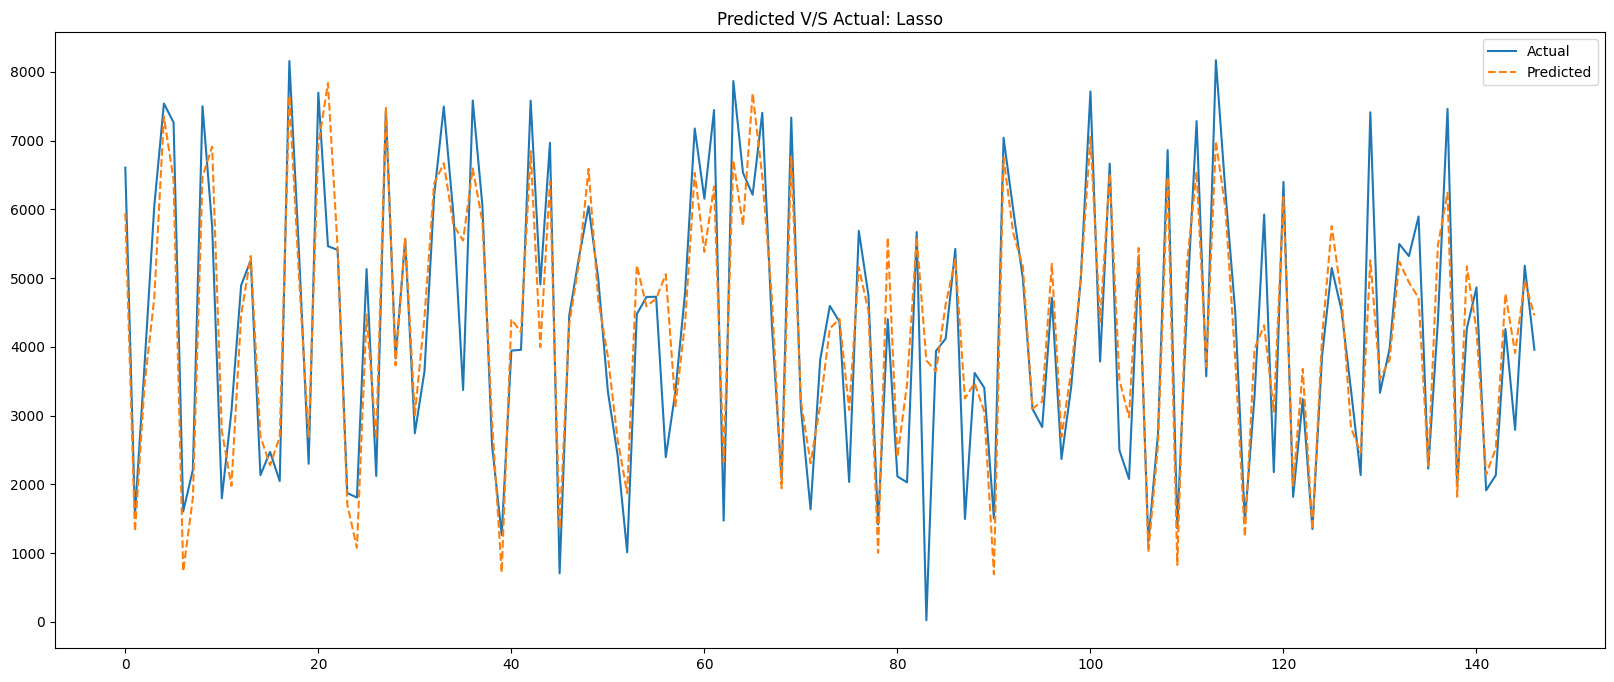

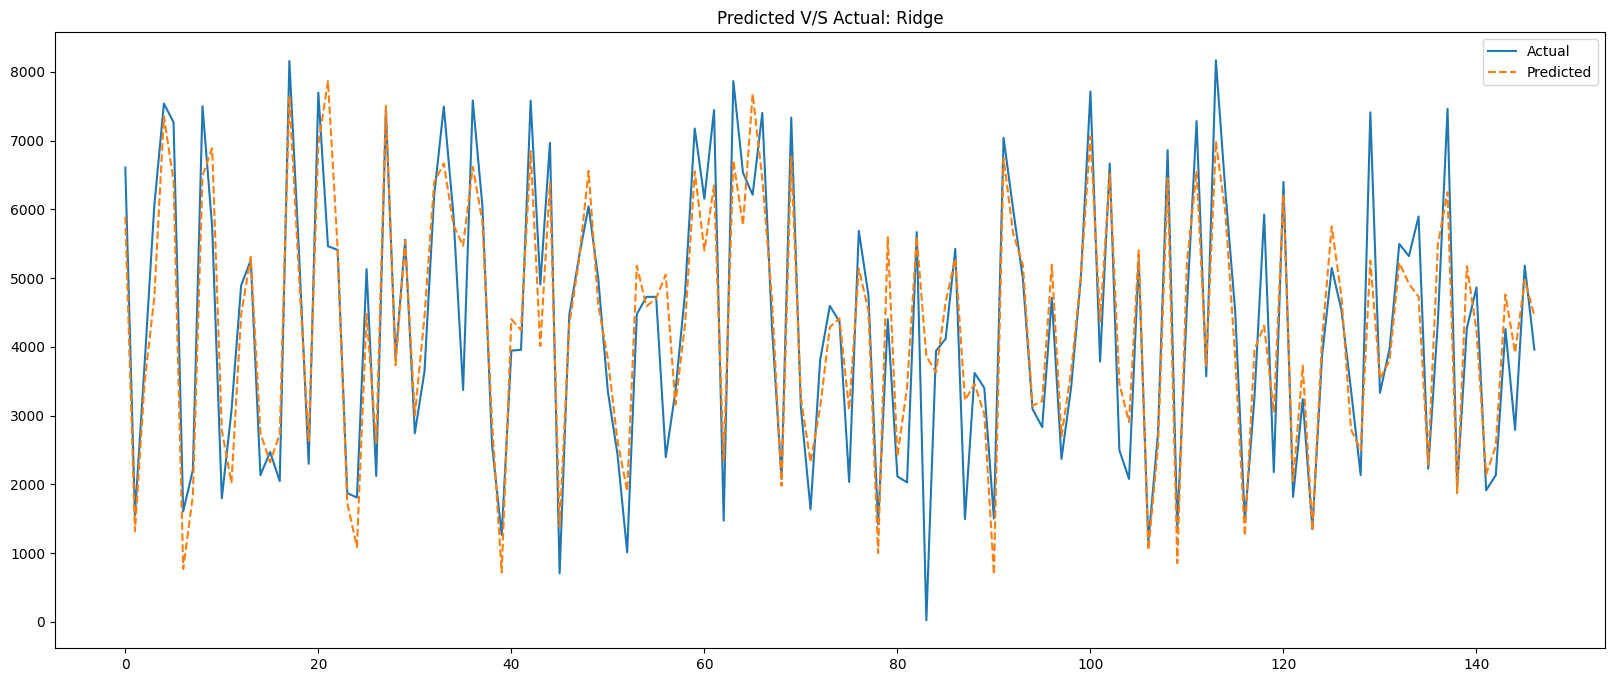

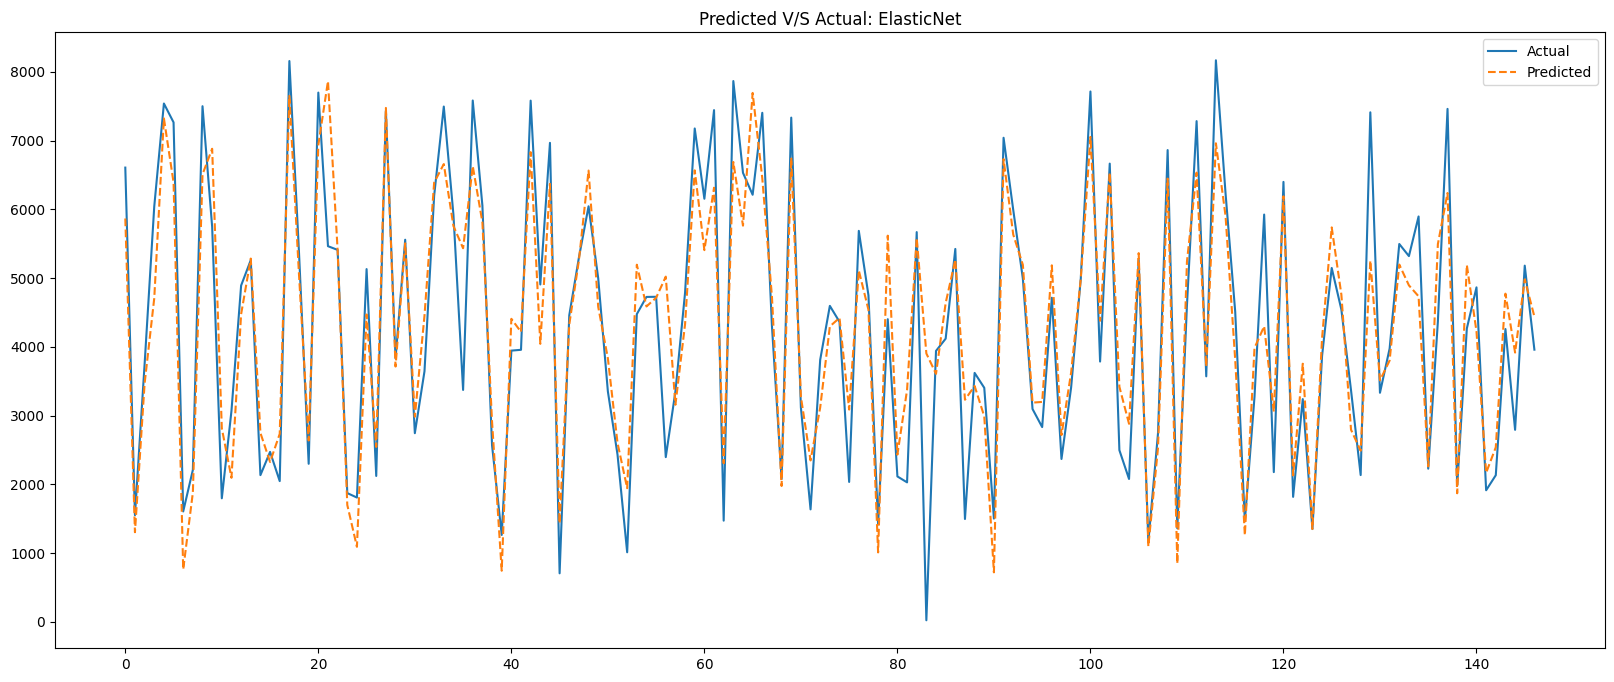

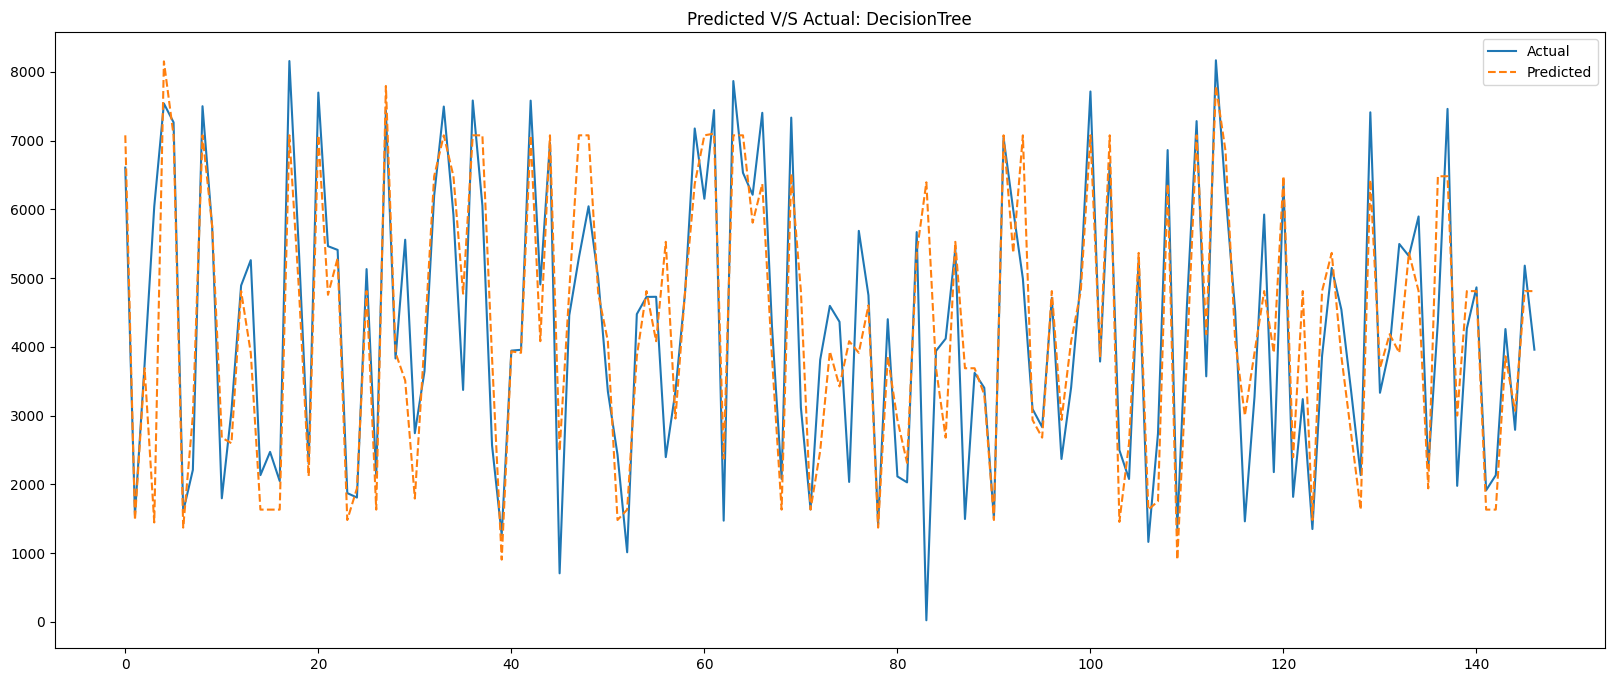

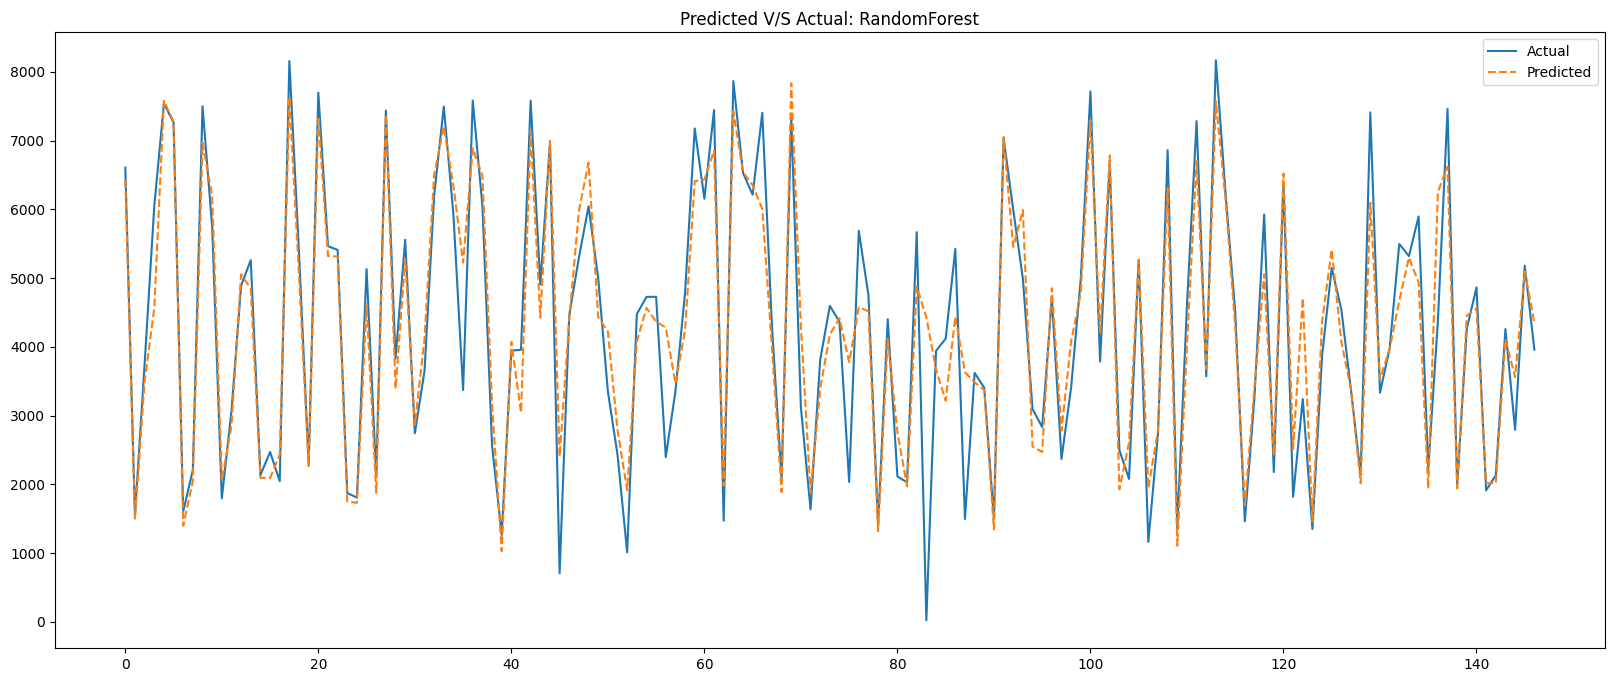

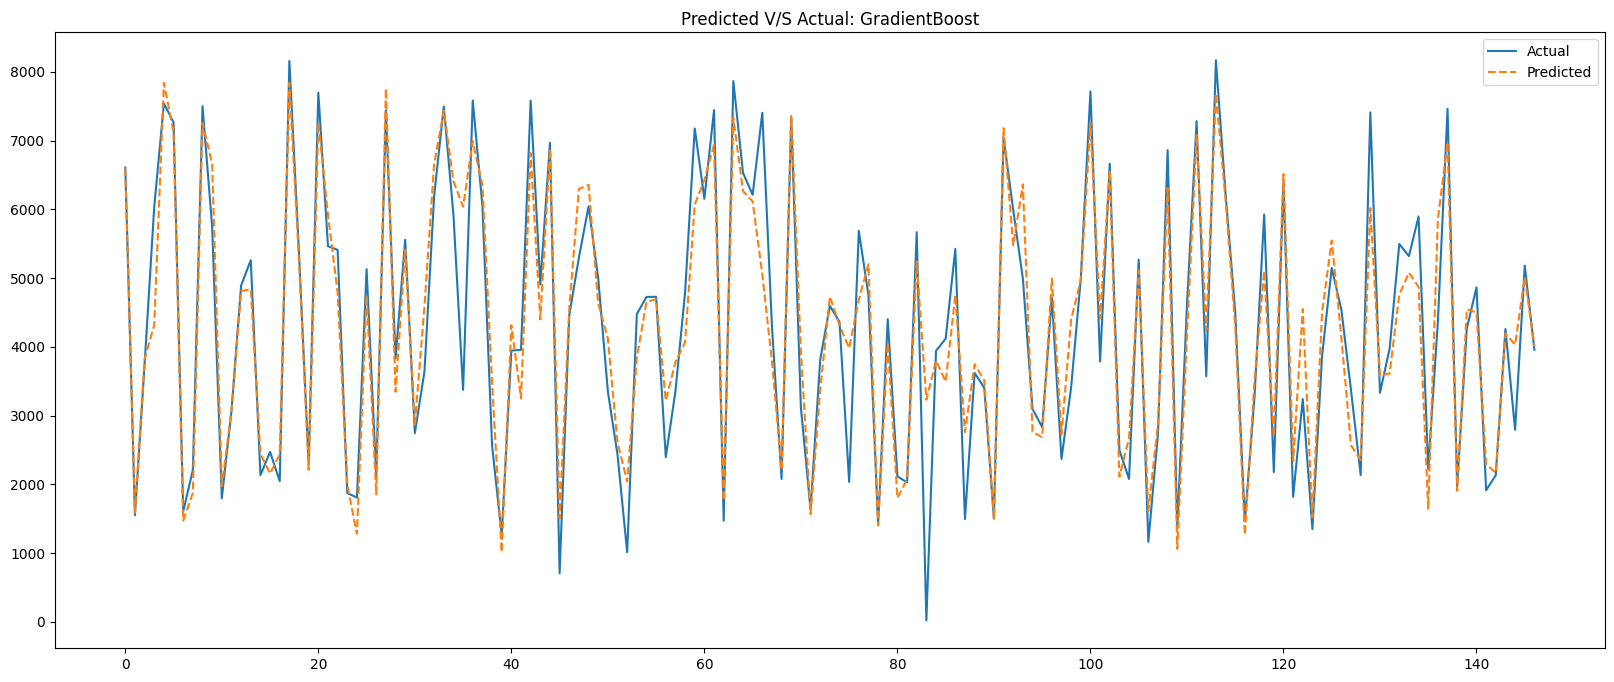

In [34]:
# Create results dictionary for all trained models
results = {}

for model_name, model in best_models.items():
    # Predict on test set
    y_pred_test = model.predict(X_test)
    
    # Store predictions and optional RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    results[model_name] = {
        "y_pred_test": y_pred_test,
        "rmse": rmse
    }

# Now you can plot
for name, result_dict in results.items():
    y_pred_test = result_dict["y_pred_test"]
    plot_Pred_vs_actual(y_pred_test, y_test, model_name=name)


## Model performance comparison

In [35]:
# ============================================================
# 1. R-SQUARED COMPARISON (Bar Chart)
# ============================================================
def plot_r2(performance_df):
    df = test_result_df.sort_values(by="R2_score", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(df["Model"], df["R2_score"])
    plt.xlabel("R² Score")
    plt.title("Model Comparison by R² Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("plot_r2_score.png")
    plt.show()

In [36]:
# ============================================================
# 2. MAE / MSE / RMSE (Grouped Bar Chart)
# ============================================================
def plot_error_metrics(performance_df):
    df = test_result_df.copy()
    metrics = ["MAE", "MSE", "RMSE"]
    
    x = np.arange(len(df["Model"]))
    w = 0.25

    plt.figure(figsize=(14, 6))
    plt.bar(x - w, df["MAE"], width=w, label="MAE")
    plt.bar(x,     df["MSE"], width=w, label="MSE")
    plt.bar(x + w, df["RMSE"], width=w, label="RMSE")

    plt.xticks(x, df["Model"], rotation=45, ha="right")
    plt.ylabel("Error Value")
    plt.title("Error Metric Comparison Across Models")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plot_error_metrics.png")
    plt.show()


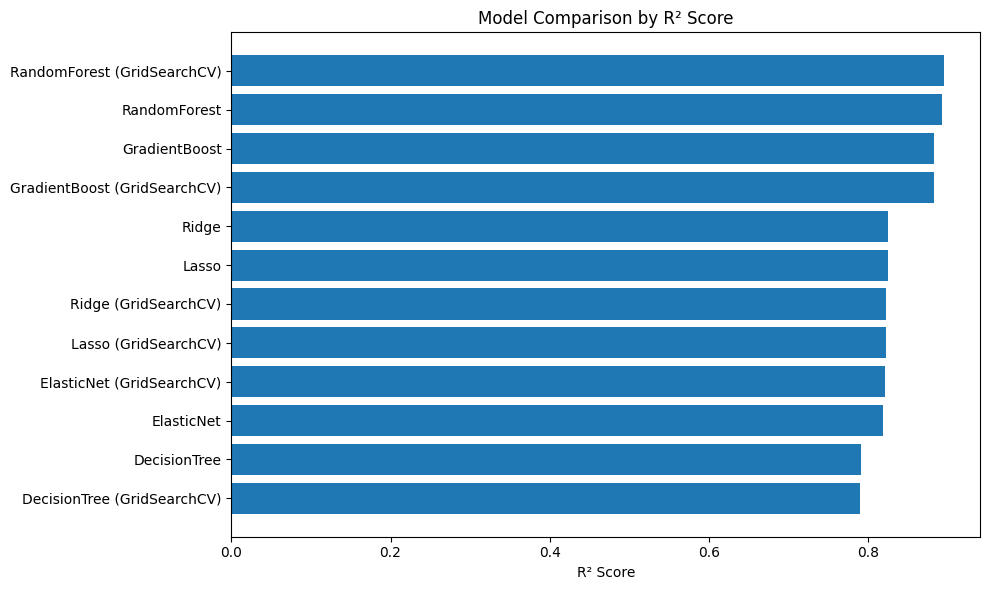

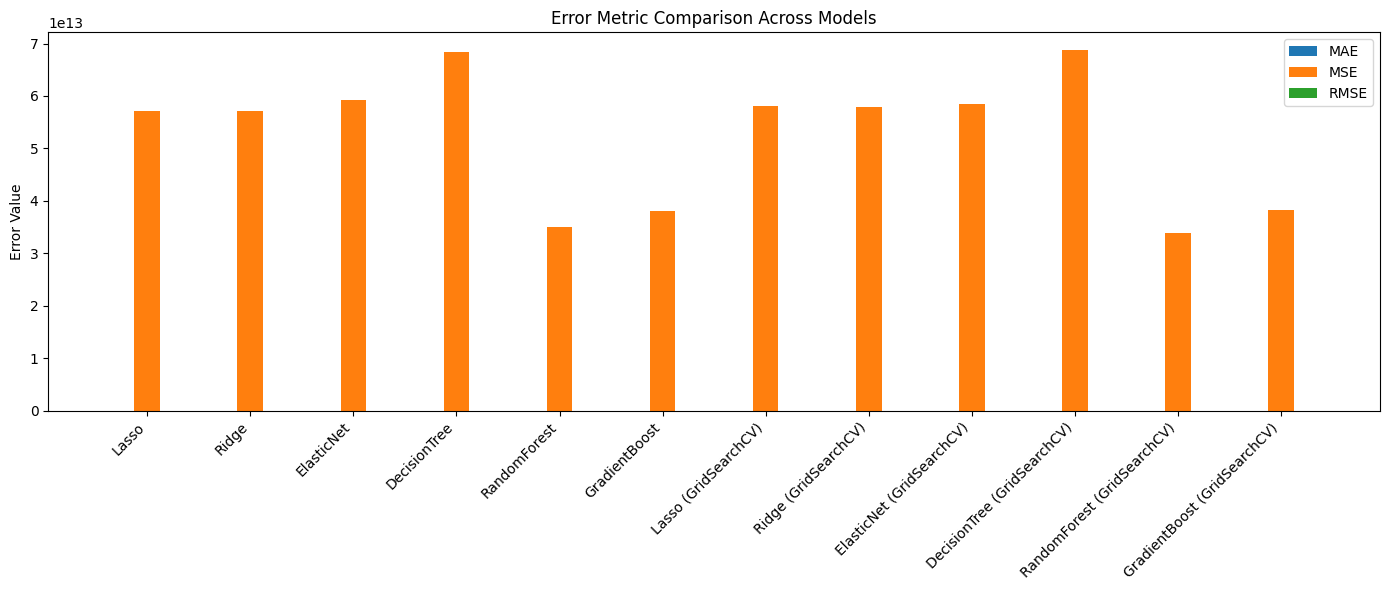

In [37]:
# ============================================================
#  RUN ALL PLOTS
# ============================================================
plot_r2(test_result_df)
plot_error_metrics(test_result_df)




## Model summary
Linear Models (Lasso, Ridge, ElasticNet):
Adjusted R² scores ~79–79.4% (base and tuned), indicating solid but not top performance.

DecisionTree:
Base: ~78.4%, Tuned: ~80.6%. Some improvement with tuning but still below ensemble models.

RandomForest:
Base: ~86.3%, Tuned: ~86.4%. Top-performing and highly robust.

GradientBoost:
Base: ~86.8%, Tuned: ~87.2%. Slightly best overall after tuning.